# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import requests
import os
import re
import string

# Create a function to find the true mapping 

In [2]:
def find_mapping(seed = None):
    normal_chars = [chr(i+97) for i in range(26)]
    nomral_chars = np.array(normal_chars)
    changed_chars = np.copy(normal_chars)
    np.random.seed(seed = seed)
    np.random.shuffle(changed_chars)
    true_mapping = {}
    for k, v in zip(normal_chars, changed_chars):
        true_mapping[k] = v
    return true_mapping

In [3]:
true_mapping = find_mapping()

In [4]:
true_mapping

{'a': 'g',
 'b': 'j',
 'c': 'p',
 'd': 'f',
 'e': 'i',
 'f': 'm',
 'g': 's',
 'h': 'e',
 'i': 'r',
 'j': 'v',
 'k': 'b',
 'l': 'y',
 'm': 'q',
 'n': 'n',
 'o': 'w',
 'p': 'u',
 'q': 'l',
 'r': 'k',
 's': 'z',
 't': 'c',
 'u': 'a',
 'v': 'h',
 'w': 'd',
 'x': 'o',
 'y': 'x',
 'z': 't'}

In [5]:
true_mapping

{'a': 'g',
 'b': 'j',
 'c': 'p',
 'd': 'f',
 'e': 'i',
 'f': 'm',
 'g': 's',
 'h': 'e',
 'i': 'r',
 'j': 'v',
 'k': 'b',
 'l': 'y',
 'm': 'q',
 'n': 'n',
 'o': 'w',
 'p': 'u',
 'q': 'l',
 'r': 'k',
 's': 'z',
 't': 'c',
 'u': 'a',
 'v': 'h',
 'w': 'd',
 'x': 'o',
 'y': 'x',
 'z': 't'}

# Creating transition matrix and the first probability 

In [6]:
M = np.ones((26,26))     # add-one smoothing
pi = np.zeros(26,)
A = np.ones((26,26,26))

In [7]:
def transition_matrix_update(ch1, ch2):
    i = ord(ch1) - 97
    j = ord(ch2) - 97
    M[i,j] += 1

In [8]:
def pi_update(ch):
    i = ord(ch) - 97
    pi[i] += 1

In [9]:
def trigram_matrix_update(ch1, ch2, ch3):
    i = ord(ch1) - 97
    j = ord(ch2) - 97
    k = ord(ch3) - 97
    A[i,j,k] += 1

# Get log probability of words happening, and use that for sentences

In [10]:
def get_word_prob(word, n=2):
    if(n==3):
        logp = np.log(pi[ord(word[0])-97])
        if(len(word)>1):
            logp += np.log(M[ord(word[0])-97, ord(word[1])-97])
            for i in range(2, len(word)):
                i_1 = ord(word[i-2]) - 97
                j_1 = ord(word[i-1]) - 97
                k_1 = ord(word[i]) - 97
                logp += np.log(A[i_1, j_1, k_1])
        return logp
    else:
        logp = np.log(pi[ord(word[0])-97])
        for i in range(1, len(word)):
            i_1 = ord(word[i-1]) - 97
            j_1 = ord(word[i]) - 97
            logp += np.log(M[i_1, j_1])
        return logp

In [11]:
def get_sentence_prob(sentence,  n=2):
    if(type(sentence) == str):      # we don't split if it is already passed as a list
        words = sentence.split()
    logp = 0
    for word in words:
        logp += get_word_prob(word, n)
    return logp

# Download the text

In [12]:
if not os.path.exists('moby_dick_new.txt'):
    print("Downloading moby dick...")
    r = requests.get('https://www.gutenberg.org/files/2701/2701-0.txt')   # change link
    with open('moby_dick_new.txt', 'w', encoding="utf-8") as f:
        f.write(r.content.decode())

# Change all the non characters to space and find the pi and M

In [15]:
#Bigram
import re
regex = re.compile('[^a-zA-Z]')
k=0
for line in open('moby_dick.txt', encoding="utf8"):
    line = line.rstrip()
    
    if line:
        line = regex.sub(' ', line) 
        tokens = line.lower().split()
        
        for token in tokens:
            ch0 = token[0]
            pi_update(ch0)
            k+=1
            for ch1 in token[1:] :
                transition_matrix_update(ch0, ch1)
                ch0 = ch1
                            

pi /= pi.sum()
M /= M.sum(axis=1, keepdims = True)

In [14]:
#trigram
import re
regex = re.compile('[^a-zA-Z]')
k=0
for line in open('moby_dick.txt', encoding="utf8"):
    line = line.rstrip()
    
    if line:
        line = regex.sub(' ', line) 
        tokens = line.lower().split()
        
        for token in tokens:
            ch0 = token[0]
            pi_update(ch0)
            k+=1
            if(len(token)>1):
                ch1 = token[1]
                transition_matrix_update(ch0, ch1)
                for i in range(2,) :
                    trigram_matrix_update(token[i-2], token[i-1], token[i])
                    
pi /= pi.sum()
M /= M.sum(axis=1, keepdims=True)
A /= A.sum(axis=2, keepdims=True)

In [487]:
print(k)

214702


In [16]:
msg = "By art is created that great Leviathan, called a Commonwealth or State—(in Latin, Civitas) which is but an artificial man.” —Opening sentence of Hobbes’s Leviathan.Silly Mansoul swallowed it without chewing, as if it had been a sprat in the mouth of a whale.” —Pilgrim’s Progress.That sea beastLeviathan, which God of all his worksCreated hugest that swim the ocean stream.” —Paradise Lost.There Leviathan,Hugest of living creatures, in the deepStretched like a promontory sleeps or swims,And seems a moving land; and at his gillsDraws in, and at his breath spouts out a sea.” —Ibid."

# Encoding the message using the true mapping

In [17]:
def encode_message(msg):
    msg = msg.lower()
    msg = regex.sub(' ', msg)
    coded_msg = ''
    for ch in msg:
        if(ch in true_mapping):   # could be space
            coded_msg += true_mapping[ch]
        else:
            coded_msg += ch
    return coded_msg

# Decoding the message using the word map

In [18]:
def decode_message(msg, word_map):
    msg = msg.lower()
    msg = regex.sub(' ', msg)
    decoded_msg = ''
    for ch in msg:
        if(ch in word_map):   # could be space
            decoded_msg += word_map[ch]
        else:
            decoded_msg += ch
    return decoded_msg

In [19]:
encoded_message = encode_message(msg)

In [20]:
dict2 = {}
 
for k, v in true_mapping.items():
    dict2[v]=k
    
decode_message(encoded_message, dict2)

'by art is created that great leviathan  called a commonwealth or state  in latin  civitas  which is but an artificial man    opening sentence of hobbes s leviathan silly mansoul swallowed it without chewing  as if it had been a sprat in the mouth of a whale    pilgrim s progress that sea beastleviathan  which god of all his workscreated hugest that swim the ocean stream    paradise lost there leviathan hugest of living creatures  in the deepstretched like a promontory sleeps or swims and seems a moving land  and at his gillsdraws in  and at his breath spouts out a sea    ibid '

# Genetic Algorithm

## Create random 20 dna strings 

In [21]:
dna_pool = []
for _ in range(20):
    dna = list(string.ascii_lowercase)
    random.shuffle(dna)
    dna_pool.append(dna)

## Create new child dna strings by changing one element at a time 

In [22]:
def evolve_offspring(dna_pool, n_children):
    offspring = []
    
    for dna in dna_pool:
        for _ in range(n_children):
            copy = dna.copy()
            j = np.random.randint(len(copy))
            k = np.random.randint(len(copy))
            
            tmp = copy[j]
            copy[j] = copy[k]
            copy[k] = tmp
            
            offspring.append(copy)
    return offspring + dna_pool

## Evolve the algorithm  

In [23]:
num_iters = 1000
scores = np.zeros(num_iters)
best_dna = None
best_map = None
best_score = float('-inf')

for i in range(num_iters):
    if i > 0 :
        dna_pool = evolve_offspring(dna_pool, 2)
    dna2score = {}
    for dna in dna_pool:
        current_map = {}
        for k, v in zip(list(string.ascii_lowercase), dna):
            current_map[v] = k        # very important line
            
        decoded_message = decode_message(encoded_message, current_map)
        score = get_sentence_prob(decoded_message, 2)
        
        dna2score[''.join(dna)] = score
        
        if(score > best_score):
            best_dna = dna
            best_map = current_map
            best_score = score
        
    scores[i] = np.mean(list(dna2score.values()))
        
    sorted_dna = sorted(dna2score.items(), key=lambda x:x[1], reverse = True)
    dna_pool = [list(k) for k, v in sorted_dna[:5]]
        
    if(i%200==0):
            print("iter:", i, " score:", scores[i], "best so far:", best_score)

iter: 0  score: -4225.065435190222 best so far: -3200.756549215328
iter: 200  score: -1292.5897667548675 best so far: -1119.8125267396347
iter: 400  score: -1250.6127798264922 best so far: -1094.3385567207897
iter: 600  score: -1302.8831617904314 best so far: -1094.3385567207897
iter: 800  score: -1232.575941482094 best so far: -1094.3385567207897


In [24]:
msg

'By art is created that great Leviathan, called a Commonwealth or State—(in Latin, Civitas) which is but an artificial man.” —Opening sentence of Hobbes’s Leviathan.Silly Mansoul swallowed it without chewing, as if it had been a sprat in the mouth of a whale.” —Pilgrim’s Progress.That sea beastLeviathan, which God of all his worksCreated hugest that swim the ocean stream.” —Paradise Lost.There Leviathan,Hugest of living creatures, in the deepStretched like a promontory sleeps or swims,And seems a moving land; and at his gillsDraws in, and at his breath spouts out a sea.” —Ibid.'

In [25]:
decoded_message = decode_message(encoded_message, best_map)

print(decoded_message)

by art is created that great leviathan  called a commonwealth or state  in latin  civitas  which is but an artificial man    opening sentence of hobbes s leviathan silly mansoul swallowed it without chewing  as if it had been a sprat in the mouth of a whale    pilgrim s progress that sea beastleviathan  which god of all his workscreated hugest that swim the ocean stream    paradise lost there leviathan hugest of living creatures  in the deepstretched like a promontory sleeps or swims and seems a moving land  and at his gillsdraws in  and at his breath spouts out a sea    ibid 


In [26]:
for true, v in true_mapping.items():
    pred = best_map[v]
    if(true!=pred):
        print("true: %s, pred: %s" % (true, pred))

true: j, pred: q
true: q, pred: x
true: x, pred: z
true: z, pred: j


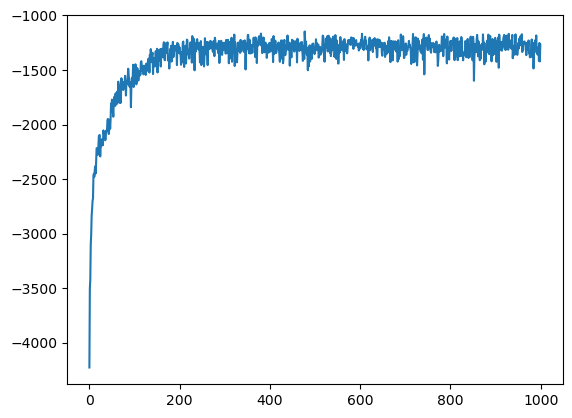

In [27]:
plt.plot(scores)